# 건들지 말것 - BASE

In [3]:
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
nwk = pd.read_csv("/home/hb/python/efficientnet_kincnn/data/final_after_1030/1104_nwk_output.csv")
nwk['nwk_score']  = MinMaxScaler().fit_transform(nwk['nwk_score'].values.reshape(-1,1))
nwk['pair11'] = nwk['kin_str_id'] + '/' + nwk['sub_str_id'] + '/' + nwk['subseq']
nwk_score_dict = {_pair: [_nwk_score, _npr_prob] for _pair, _nwk_score, _npr_prob in zip(nwk['pair11'], nwk['nwk_score'], nwk['npr_prob'])}
kin_only_in_psp = list({'ENSP00000362680': 681,
 'ENSP00000229795': 293,
 'ENSP00000500386': 280,
 'ENSP00000378974': 221,
 'ENSP00000391090': 205,
 'ENSP00000313950': 199,
 'ENSP00000346671': 198,
 'ENSP00000477713': 121,
 'ENSP00000381531': 117,
 'ENSP00000428924': 111,
 'ENSP00000356070': 97,
 'ENSP00000390535': 96,
 'ENSP00000394560': 81,
 'ENSP00000364898': 74,
 'ENSP00000380044': 61,
 'ENSP00000340373': 51,
 'ENSP00000358335': 41,
 'ENSP00000344220': 40,
 'ENSP00000264972': 37,
 'ENSP00000429744': 35,
 'ENSP00000341189': 34,
 'ENSP00000393312': 34,
 'ENSP00000479889': 33,
 'ENSP00000347942': 31}.keys())

In [4]:

def load_train_test(train_path, test_path):

    train_dirs = [f'{train_path}/{x}' for x in os.listdir(train_path) if 'train' in x ]
    test_dirs = [f'{test_path}/{x}' for x in os.listdir(test_path) if 'test' in x]

    train_list = []
    test_list = []
    for train, test_dir in zip(train_dirs, test_dirs):
        train_list.append(pd.read_csv(train))
        test = pd.read_csv(test_dir)
        # test['pair11'] = test['kin_id'] + '/' + test['sub_id'] + '/' + test['subseq'].apply(lambda x: x[2:-2])
        test['pair11'] = test['kin_str_id'] + '/' + test['sub_str_id'] + '/' + test['subseq'].apply(lambda x: x[2:-2])
        test_list.append(test)

    return train_list, test_list

train_list, test_list = load_train_test('/home/hb/python/efficientnet_kincnn/data/final_after_1030/Dataset/KMD_notinclude_by_kinase_level', '/home/hb/python/efficientnet_kincnn/data/final_after_1030/Dataset/KMD_notinclude_by_kinase_level/test_result')
df = pd.DataFrame(columns=['kin_id', 'KINCNN_AUC', 'NWK_AUC', 'NPR_AUC', '#T_test', '#F_test', '#T_train', '#F_train', 'psp_only'])

In [5]:
def make_result_df(train_list, test_list, save_path=False):

    result_df_list = []

    for idxx, (train, test) in enumerate(zip(train_list, test_list)):
        df = pd.DataFrame(columns=['kin_id', 'KINCNN_AUC', 'NWK_AUC', 'NPR_AUC', '#T_test', '#F_test', '#T_train', '#F_train', 'psp_only'])
        # print(idxx)
        df['kin_id'] = test['kin_str_id'].unique()
        N_t_in_train = {}
        N_f_in_train = {}
        for i in df['kin_id'].unique():
            tt = train.query('kin_str_id == @i')
            N_t_in_train[i] = len(tt[tt['answer']==1])
            N_f_in_train[i] = len(tt[tt['answer']==0])
        df['#T_train'] = N_t_in_train.values()
        df['#F_train'] = N_f_in_train.values()

        N_t_in_test = {}
        N_f_in_test = {}
        for i in df['kin_id'].unique():
            tt = test.query('kin_str_id == @i')
            N_t_in_test[i] = len(tt[tt['answer']==1])
            N_f_in_test[i] = len(tt[tt['answer']==0])
        df['#T_test'] = N_t_in_test.values()
        df['#F_test'] = N_f_in_test.values()

        df['psp_only'] = df['kin_id'].apply(lambda x: 'O' if x in kin_only_in_psp else np.nan)
        """
        - KINCNN probs값
        - Family 정보
        - NWK의 probs값 로딩"""
        test_result = test[['pair11', 'probs']]
        total = pd.concat([train, test], ignore_index=True)
        T_total = total[total['answer']==1]
        famdict = {kin_id: _Family for kin_id, _Family in zip(T_total.kin_id, T_total.Family)}
        test['Family'] = test['kin_id'].map(famdict)
        nwk_result = nwk[['pair11', 'nwk_score', 'npr_prob']]
        test_result = test[['kin_str_id', 'Family', 'kin_id', 'pair_id', 'pair11', 'probs', 'answer']]

        result = pd.merge(test_result, nwk_result, on='pair11', how='left').sort_values(by='pair_id', ignore_index=True)
        result_only_in_psp = result[result['nwk_score'].isna()]
        result_all = result[~result['nwk_score'].isna()]  

        auc_dict = {}
        for idx, kin_id in enumerate(df.kin_id.unique()):
            try:
                _df = result_all[result_all['kin_str_id']==kin_id].reset_index(drop=True)
                if len(_df) == 0:
                    _df = result_only_in_psp[result_only_in_psp['kin_str_id']==kin_id].reset_index(drop=True)
                _answer = np.array(_df.answer)
                kincnn_probs = np.array(_df.probs)
                kincnn_auc = roc_auc_score(_answer, kincnn_probs)
                _family = _df.Family.unique()[0]

                if kin_id in result_all.kin_str_id.unique():
                    
                    nwk_probs = np.array(_df.nwk_score)
                    npr_probs = np.array(_df.npr_prob)
                    
                    nwk_auc = roc_auc_score(_answer, nwk_probs)
                    npr_auc = roc_auc_score(_answer, npr_probs)
                    auc_dict[kin_id] = [kincnn_auc, nwk_auc, npr_auc, _family]
                    # print(kin_id)
                else:
                    auc_dict[kin_id] = [kincnn_auc, np.nan, np.nan, _family]
            except:
                pass
        df['KINCNN_AUC'] = df['kin_id'].apply(lambda x: auc_dict[x][0] if x in auc_dict.keys() else np.nan)
        df['NWK_AUC'] = df['kin_id'].apply(lambda x: auc_dict[x][1] if x in auc_dict.keys() else np.nan)
        df['NPR_AUC'] = df['kin_id'].apply(lambda x: auc_dict[x][2] if x in auc_dict.keys() else np.nan)
        df['Family'] = df['kin_id'].apply(lambda x: auc_dict[x][3] if x in auc_dict.keys() else np.nan)  

        df_psp_only = df[~df['psp_only'].isna()].reset_index(drop=True)
        df_pspnwk = df[df['psp_only'].isna()].reset_index(drop=True)
        df_pspnwk['rank'] = 3
        for idx, _kin_id in enumerate(df_pspnwk['kin_id']):
                if df_pspnwk['KINCNN_AUC'][idx] >= df_pspnwk['NWK_AUC'][idx]:
                    df_pspnwk['rank'][idx] -=1
                if df_pspnwk['KINCNN_AUC'][idx] >= df_pspnwk['NPR_AUC'][idx]:
                    df_pspnwk['rank'][idx] -=1
        df_pspnwk['rank'] = df_pspnwk['rank'].apply(lambda x: f'{str(x)}위')
        df_pspnwk.sort_values(by='rank', inplace=True, ignore_index=True)
        print('==='*20)
        print(f'Dataset-{idxx}')
        print('- 전체 개별 kinase 개수 : {}개'.format(len(df_pspnwk), ))
        print('- KINCNN이 성능 1위인 개별 kinase 개수 : {}개'.format(len(df_pspnwk[df_pspnwk['rank']=='1위'])))
        print('- KINCNN이 성능 3위인 개별 kinase 개수 : {}개'.format(len(df_pspnwk[df_pspnwk['rank']=='3위']),))
        df_pspnwk = df_pspnwk.dropna(axis=0, subset='KINCNN_AUC', ).reset_index(drop=True)
        df = pd.concat([df_pspnwk, df_psp_only], ignore_index=True)
        if save_path:
            df.to_csv(f'{save_path}_{idxx}.csv', index=False)
        # display(df.head(2))
        result_df_list.append(df)
    return result_df_list

result_df_list = make_result_df(train_list, test_list, '/home/hb/python/efficientnet_kincnn/data/final_after_1030/Dataset/KMD_notinclude_by_kinase_level/test_result/benchmark/kmdni_best_model')

Dataset-0
- 전체 개별 kinase 개수 : 31개
- KINCNN이 성능 1위인 개별 kinase 개수 : 10개
- KINCNN이 성능 3위인 개별 kinase 개수 : 13개
Dataset-1
- 전체 개별 kinase 개수 : 31개
- KINCNN이 성능 1위인 개별 kinase 개수 : 13개
- KINCNN이 성능 3위인 개별 kinase 개수 : 8개
Dataset-2
- 전체 개별 kinase 개수 : 31개
- KINCNN이 성능 1위인 개별 kinase 개수 : 12개
- KINCNN이 성능 3위인 개별 kinase 개수 : 13개
Dataset-3
- 전체 개별 kinase 개수 : 31개
- KINCNN이 성능 1위인 개별 kinase 개수 : 10개
- KINCNN이 성능 3위인 개별 kinase 개수 : 13개


In [9]:
import matplotlib.pyplot as plt

def benchmark_visualization_by_kinase(result_df_list, save_path=False, show_plot=False):
    benchmark_visualization_result = []
    for idx, df in enumerate(result_df_list):
        df_benchmark = df[~df['rank'].isna()].reset_index(drop=True)
        COLUMNS = 5
        ROWS = len(df_benchmark)//COLUMNS + 1
        if len(df_benchmark)%COLUMNS == 0:
            ROWS -= 1
        fig, axes = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(15, 30))
        for i in range(len(df_benchmark)):
            
            # if df_benchmark.iloc[i]['rank'] == '1위':
            colors = ['gold', 'silver', 'silver']
            # else:
                # colors = ['silver']*3
            row = i//COLUMNS
            column = i%COLUMNS
            
            axes[row, column].bar([0, 1, 2], df_benchmark.iloc[i].to_list()[1:4], color=colors)
            axes[row, column].set_xticks([0, 1, 2], ['KINCNN', 'NetworKin', 'NetPhorest'])
            axes[row, column].set_title(f'{df_benchmark.iloc[i].to_list()[0]}', fontsize=15)
            fig.tight_layout()
        if save_path:
            fig.savefig(f'{save_path}_{idx}.png')
        benchmark_visualization_result.append(fig)
        if ~show_plot:
            plt.close()
    return benchmark_visualization_result

# benchmark_visualization_result = benchmark_visualization_by_kinase(result_df_list, '/home/hb/python/efficientnet_kincnn/data/final_after_1030/Dataset/KMD_notinclude_by_kinase_level/test_result/benchmark/benchmark_vis')
benchmark_visualization_result = benchmark_visualization_by_kinase(result_df_list, '/home/hb/python/efficientnet_kincnn/data/final_after_1030/Dataset/KMD_notinclude_by_kinase_level/test_result/benchmark/benchmark_vis')

In [14]:
# df_pspnwk.to_csv('benchmark_test0_result.csv', index=False)
# df_psp_only.to_csv('psp_only_test0_result.csv', index=False)

In [20]:
rst = result_df_list[0]
for _family in rst.Family.unique():
    # print(_family)
    df_fam = rst[rst['Family']==_family]


In [2]:
rst_cdk = rst[rst['Family']=='CDK'].reset_index(drop=True)
df = rst_cdk
df_benchmark = df[~df['rank'].isna()].reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 30))
position = 0
axes[position].bar([0, 1, 2], df_benchmark.iloc[0].to_list()[1:4], color=['gold', 'silver', 'silver'])

NameError: name 'rst' is not defined

Text(0.5, 1.0, 'CDK')

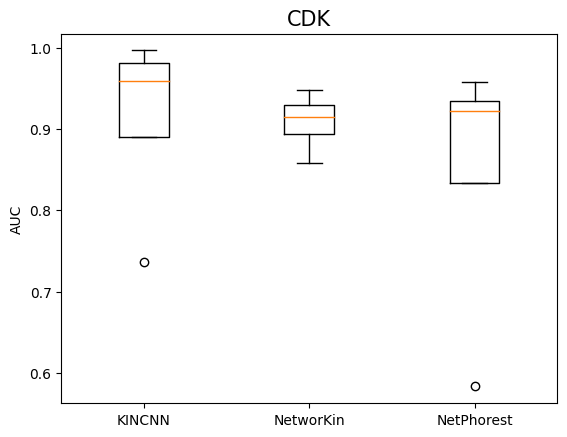

In [84]:
fig, axes = plt.subplots(1)
# axes.bar()
axes.boxplot( df_benchmark[['KINCNN_AUC', 'NWK_AUC', 'NPR_AUC']], )
axes.set_xticks([1, 2, 3])
axes.set_xticklabels(['KINCNN', 'NetworKin', 'NetPhorest'])
axes.set_ylabel('AUC')
axes.set_title(df_benchmark['Family'].unique()[0], fontsize=15)
# plt.boxplot([0, 1, 2],  df_benchmark[['KINCNN_AUC', 'NWK_AUC', 'NPR_AUC']])
# plt.xticks(['KINCNN_AUC', 'NWK_AUC', 'NPR_AUC'])

In [54]:
result_df_list[0].iloc[39]['rank'] == 

False

In [65]:
t = result_df_list[0]
# t = t[~t['rank'].isna()]
t = t[t['rank'].isin(['1위', '2위', '3위'])]
t

,kin_id,KINCNN_AUC,NWK_AUC,NPR_AUC,#T_test,#F_test,#T_train,#F_train,psp_only,Family,rank
0,ENSP00000261798,0.835743,0.733037,0.700593,93,93,87,87,NaN,CK1,1위
1,ENSP00000216911,0.781818,0.752468,0.713766,77,77,68,68,NaN,Aur,1위
2,ENSP00000257904,0.996364,0.858182,0.957727,55,55,30,30,NaN,CDK,1위
3,ENSP00000346148,0.833507,0.786311,0.783177,87,87,142,142,NaN,CAMKL,1위
4,ENSP00000222330,0.738095,0.646520,0.717949,42,42,61,61,NaN,GSK,1위
5,ENSP00000309591,0.922022,0.900587,0.912980,287,287,701,701,NaN,PKA,1위
6,ENSP00000363092,0.961957,0.820652,0.953804,23,23,69,69,NaN,PKG,1위
7,ENSP00000382697,0.821429,0.821429,0.776786,24,24,57,57,NaN,DMPK,1위
8,ENSP00000265734,0.975862,0.948276,0.925862,29,29,21,21,NaN,CDK,1위
9,ENSP00000266970,0.941376,0.923124,0.917229,233,233,224,224,NaN,CDK,1위


In [70]:
import matplotlib.pyplot as plt

def benchmark_visualization_by_family(result_df_list, save_path=False):
    benchmark_visualization_result = []
    for idx, df in enumerate(result_df_list):
        df_benchmark = df[~df['rank'].isna()].reset_index(drop=True)
        df_benchmark = df_benchmark[df_benchmark['rank'].isin(['1위', '2위', '3위'])]

        for _family in df_benchmark.Family.unique():
            
            df_family = df_benchmark[df_benchmark['Family']==_family]
            COLUMNS = 4
            ROWS = len(df_family)//COLUMNS + 1
            if len(df_family)%COLUMNS == 0:
                ROWS -= 1
            fig, axes = plt.subplots(nrows=ROWS, ncols=COLUMNS, figsize=(15, ROWS*7))
            for i in range(len(df_family)):
                
                
                if df_family.iloc[i]['rank'] == '1위':
                    colors = ['green', 'silver', 'silver']
                else:
                    colors = ['gold', 'silver', 'silver']
                row = i//COLUMNS
                column = i%COLUMNS
                if ROWS == 1:
                    position = column
                else:
                    position = row, column
                axes[position].bar([0, 1, 2], df_family.iloc[i].to_list()[1:4], color=colors)
                axes[position].set_xticks([0, 1, 2], ['KINCNN', 'NetworKin', 'NetPhorest'])
                axes[position].set_title(f'{df_family.iloc[i].to_list()[0]}', fontsize=15)
                # print(len(df_family))
                # print(COLUMNS * ROWS)
            if len(df_family) < COLUMNS * ROWS:
                extra = (COLUMNS * ROWS) - len(df_family)
                if ROWS == 1:
                    for _extra in range(extra):
                        position = (COLUMNS - _extra -1)
                        axes[position].axis('off')
                elif ROWS > 1:
                    for _extra in range(extra):
                        position = ROWS-1, (COLUMNS - _extra -1)
                        axes[position].axis('off')
            fig.suptitle(df_family['Family'].unique()[0], fontsize=20)
            fig.tight_layout()
            if save_path:
                save_dir = f'{save_path}/test{idx}'
                os.makedirs(save_dir, exist_ok=True)
                fig.savefig(f'{save_dir}/{_family}.png')
            benchmark_visualization_result.append(fig)
    return benchmark_visualization_result

benchmark_visualization_result = benchmark_visualization_by_family(result_df_list, '/home/hb/python/efficientnet_kincnn/data/final_after_1030/Dataset/KMD_notinclude_by_kinase_level/test_result/benchmark/by_family_level')

# 여기까지


In [24]:
# import numpy as np
# test_score_list = []
# for test in test_list:
#     # test = test[test['pair11'].isin(nwk_score_dict.keys())]
#     # test['nwk_score'] = test['pair11'].apply(lambda x: nwk_score_dict[x][0] if x in list(nwk_score_dict.keys()) else np.nan)
#     # test['npr_score'] = test['pair11'].apply(lambda x: nwk_score_dict[x][1] if x in list(nwk_score_dict.keys()) else np.nan)
#     # test = test[~test['nwk_score'].isna()]
#     test_result = pd.merge(left=test, right=nwk_result, on='pair11', how='left')
#     test_score_list.append(test_result)

In [135]:
from sklearn.metrics import roc_auc_score

# for test in test_result:
# test = test_result[~test_result['nwk_score_minmax'].isna()]
score_dict_by_kinid = {}
test = test_result
test_other = test_result[~test_result['nwk_score_minmax'].isna()]
test_psponly = test_result[test_result['nwk_score_minmax'].isna()]

for idx, kin_id in enumerate(df.kin_id.unique()):

    try:
        _kin_sort = test_other.query('kin_str_id == @kin_id')
        score_dict_by_kinid[kin_id] = [roc_auc_score(np.array(_kin_sort['answer']), np.array(_kin_sort[x])) for x in ['probs', 'nwk_score_minmax', 'npr_prob']]

    except:
        # score_dict_by_kinid[kin_id] = [roc_auc_score(np.array(_kin_sort['answer']), np.array(_kin_sort['probs']))]
        pass

for idx, kin_id in enumerate(df.kin_id.unique()):

    try:
        _kin_sort = test_psponly.query('kin_str_id == @kin_id')
        score_dict_by_kinid[kin_id] = [roc_auc_score(np.array(_kin_sort['answer']), np.array(_kin_sort['probs']))]

    except:
        # score_dict_by_kinid[kin_id] = [roc_auc_score(np.array(_kin_sort['answer']), np.array(_kin_sort['probs']))]
        pass

In [149]:
for idx, kin_id in enumerate(df.kin_id.unique()):
    try:
        if len(score_dict_by_kinid[kin_id]) > 1:
            df['KINCNN_AUC'][idx] = score_dict_by_kinid[kin_id][0]
            df['NWK_AUC'][idx] = score_dict_by_kinid[kin_id][1]
            df['NPR_AUC'][idx] = score_dict_by_kinid[kin_id][2]
        else:
            df['KINCNN_AUC'][idx] = score_dict_by_kinid[kin_id][0]
    except:
        pass

/tmp/ipykernel_881576/2182443623.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KINCNN_AUC'][idx] = score_dict_by_kinid[kin_id][0]
/tmp/ipykernel_881576/2182443623.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KINCNN_AUC'][idx] = score_dict_by_kinid[kin_id][0]
/tmp/ipykernel_881576/2182443623.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NWK_AUC'][idx] = score_dict_by_kinid[kin_id][1]
/tmp/ipykernel_881576/

In [161]:
score_dict_by_kinid['ENSP00000324856'] = []
score_dict_by_kinid['ENSP00000324856'].append(roc_auc_score(test_result[test_result['kin_str_id'] == 'ENSP00000324856'].answer, test_result[test_result['kin_str_id'] == 'ENSP00000324856'].probs))
# score_dict_by_kinid['ENSP00000324856'].append(roc_auc_score(test_result[test_result['kin_str_id'] == 'ENSP00000324856'].answer, test_result[test_result['kin_str_id'] == 'ENSP00000324856'].nwk_score_minmax))
score_dict_by_kinid['ENSP00000324856'].append(roc_auc_score(test_result[test_result['kin_str_id'] == 'ENSP00000324856'].answer, test_result[test_result['kin_str_id'] == 'ENSP00000324856'].npr_prob))

ValueError: Input contains NaN.

In [155]:
roc_auc_score(test_result[test_result['kin_str_id'] == 'ENSP00000324856'].answer, test_result[test_result['kin_str_id'] == 'ENSP00000324856'].probs)

0.8086419753086419

In [142]:
try:
    # df['KINCNN_AUC'] = df['kin_id'].apply(lambda x: score_dict_by_kinid[x][0] if x in score_dict_by_kinid.keys() else np.nan)
    df['NWK_AUC'] = df['kin_id'].apply(lambda x: score_dict_by_kinid[x][1] if x in score_dict_by_kinid.keys() else np.nan)
    df['NPR_AUC'] = df['kin_id'].apply(lambda x: score_dict_by_kinid[x][2] if x in score_dict_by_kinid.keys() else np.nan)
except:
    # df['KINCNN_AUC'] = df['kin_id'].apply(lambda x: score_dict_by_kinid[x][0] if x in score_dict_by_kinid.keys() else np.nan)
    pass
# df['KINCNN_AUC'] = df['kin_id'].apply(lambda x: score_dict_by_kinid[x][0] if df[df['kin_id']==x]['psp_only'][0]=='O' else np.nan)

In [42]:
kin_id = 'ENSP00000217244'
_kin_sort = test.query('kin_str_id == @kin_id')
_kin_sort = _kin_sort[~_kin_sort['nwk_score_minmax'].isna()]
roc_auc_score(_kin_sort['answer'], _kin_sort['nwk_score_minmax'])

0.9161976519002664

In [43]:
df['NWK_AUC'][1] = roc_auc_score(_kin_sort['answer'], _kin_sort['nwk_score_minmax'])

/tmp/ipykernel_881576/1752414953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NWK_AUC'][1] = roc_auc_score(_kin_sort['answer'], _kin_sort['nwk_score_minmax'])


In [44]:
df

,kin_id,KINCNN_AUC,NWK_AUC,NPR_AUC,#T_test,#F_test,#T_train,#F_train,psp_only
0,ENSP00000500386,0.831111,NaN,NaN,15,15,265,265,O
1,ENSP00000217244,0.923421,0.916198,NaN,324,324,443,443,X
2,ENSP00000216911,0.727441,NaN,NaN,77,77,68,68,X
3,ENSP00000261799,0.792969,NaN,NaN,16,16,16,16,X
4,ENSP00000256443,0.795005,NaN,NaN,31,31,27,27,X
5,ENSP00000346148,0.757564,NaN,NaN,87,87,142,142,X
6,ENSP00000360290,0.8704,NaN,NaN,25,25,33,33,X
7,ENSP00000380044,0.697778,NaN,NaN,15,15,46,46,O
8,ENSP00000364898,0.937778,NaN,NaN,15,15,59,59,O
9,ENSP00000356070,0.906667,NaN,NaN,15,15,82,82,O


In [122]:
df_psp_only = df[df['psp_only']=='O'].reset_index(drop=True)
df_pspnwk = df[df['psp_only']=='X'].reset_index(drop=True)

df_pspnwk['rank'] = 3
for idx, _kin_id in enumerate(df_pspnwk['kin_id']):
    if df_pspnwk['psp_only'][idx] == 'X':
        if df_pspnwk['KINCNN_AUC'][idx] >= df_pspnwk['NWK_AUC'][idx]:
            df_pspnwk['rank'][idx] -=1
        if df_pspnwk['KINCNN_AUC'][idx] >= df_pspnwk['NPR_AUC'][idx]:
            df_pspnwk['rank'][idx] -=1
df_pspnwk.sort_values(by='rank', inplace=True, ignore_index=True)
print(len(df_pspnwk), len(df_pspnwk[df_pspnwk['rank']==1]))
df_pspnwk

31 0


,kin_id,KINCNN_AUC,NWK_AUC,NPR_AUC,#T_test,#F_test,#T_train,#F_train,psp_only,rank
0,ENSP00000217244,0.915562,NaN,NaN,324,324,443,443,X,3
1,ENSP00000361892,0.774691,NaN,NaN,18,18,25,25,X,3
2,ENSP00000362608,0.697704,NaN,NaN,28,28,48,48,X,3
3,ENSP00000355966,0.5456,NaN,NaN,25,25,12,12,X,3
4,ENSP00000303830,0.97,NaN,NaN,20,20,33,33,X,3
5,ENSP00000278568,0.768595,NaN,NaN,33,33,67,67,X,3
6,ENSP00000365012,0.4992,NaN,NaN,25,25,4,4,X,3
7,ENSP00000261798,0.842063,NaN,NaN,93,93,87,87,X,3
8,ENSP00000311005,0.66,NaN,NaN,20,20,12,12,X,3
9,ENSP00000312262,0.884661,NaN,NaN,29,29,75,75,X,3
